In [2]:
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from global_land_mask import globe

import seaborn as sns

In [3]:
import psutil

# Get the available memory in bytes
available_memory = psutil.virtual_memory().available
# Convert to gigabytes for easier interpretation
available_memory_gb = available_memory / (1024 ** 3)

print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 172.91 GB


In [4]:
qa = "aerdt_aod_qa3"
FILE_AHI_agg = f"/home/svisaga/clavrx/output/nc/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_{qa}.nc"
C_AHI_agg = xarray.open_dataset(FILE_AHI_agg)
C_AHI_agg

<xarray.Dataset>
Dimensions:    (longitude: 186, latitude: 158)
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15
Data variables:
    aod_Mean   (latitude, longitude) float64 ...

In [5]:
FILE_MUSICAv0_agg = f"/home/svisaga/clavrx/output/nc/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_MUSICAv0_{qa}.nc"
C_MUSICAv0_agg = xarray.open_dataset(FILE_MUSICAv0_agg)
C_MUSICAv0_agg 


<xarray.Dataset>
Dimensions:  (lat: 158, lon: 186)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2
Data variables:
    AODVIS   (lat, lon) float32 ...

In [6]:
mean_aod = C_AHI_agg['aod_Mean']
mean_aod_model = C_MUSICAv0_agg['AODVIS']

In [7]:
# Ensure NaNs in mean_aod match NaNs in mean_aod_model using a for loop
for latitude in mean_aod.latitude:
    for longitude in mean_aod.longitude:
        value = mean_aod.sel(latitude=latitude, longitude=longitude)
        if (value < 0):
            mean_aod.loc[dict(latitude=latitude, longitude=longitude)] = np.nan
            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan
        if (np.isnan(value)):
            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan

In [8]:
mean_aod

<xarray.DataArray 'aod_Mean' (latitude: 158, longitude: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [0.278079, 0.162147, 0.088982, ..., 0.129684, 0.148076, 0.136794],
       [0.165154, 0.134556, 0.113842, ..., 0.144941, 0.148045, 0.14841 ],
       [0.150985, 0.105976, 0.141481, ..., 0.140542, 0.157605, 0.166655]])
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15

In [9]:
mean_aod_model


<xarray.DataArray 'AODVIS' (lat: 158, lon: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [0.280338, 0.218502, 0.099624, ..., 0.0566  , 0.065361, 0.064997],
       [0.247699, 0.208446, 0.117989, ..., 0.061133, 0.067204, 0.0729  ],
       [0.192307, 0.104875, 0.084538, ..., 0.073471, 0.070398, 0.070519]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2

In [10]:
mean_aod_model_ocean = mean_aod_model
mean_aod_ocean = mean_aod

for latitude in mean_aod.latitude:
    for longitude in mean_aod.longitude:
        if globe.is_land(latitude.item(), longitude.item()):
            mean_aod_model_ocean.loc[dict(lat=latitude, lon=longitude)] = np.nan
            mean_aod_ocean.loc[dict(latitude=latitude, longitude=longitude)] = np.nan

In [11]:
mean_aod_model_ocean

<xarray.DataArray 'AODVIS' (lat: 158, lon: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ..., 0.0566  , 0.065361, 0.064997],
       [     nan,      nan,      nan, ..., 0.061133, 0.067204, 0.0729  ],
       [     nan,      nan,      nan, ..., 0.073471, 0.070398, 0.070519]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2

In [12]:
mean_aod_ocean

<xarray.DataArray 'aod_Mean' (latitude: 158, longitude: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ..., 0.129684, 0.148076, 0.136794],
       [     nan,      nan,      nan, ..., 0.144941, 0.148045, 0.14841 ],
       [     nan,      nan,      nan, ..., 0.140542, 0.157605, 0.166655]])
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15

# Open Lev=26 winds 887 hPa

In [13]:
ds_wind = xarray.open_mfdataset("/home/svisaga/MUSICA_ANALYSES/MUSICAv0_AOD_U_V_regridded/MUSICAv0_AOD_U_V_SEAcut_25km_2019-*.nc")
ds_wind_ = ds_wind.sel(time=slice("2019-08-24", "2019-10-05")).isel(lev=26)
ds_wind_mean = ds_wind_.mean(dim="time")
ds_wind_mean

<xarray.Dataset>
Dimensions:  (lat: 158, lon: 186)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2
    lev      float32 887.0
Data variables:
    AODVIS   (lat, lon) float32 dask.array<chunksize=(158, 186), meta=np.ndarray>
    U        (lat, lon) float32 dask.array<chunksize=(158, 186), meta=np.ndarray>
    V        (lat, lon) float32 dask.array<chunksize=(158, 186), meta=np.ndarray>

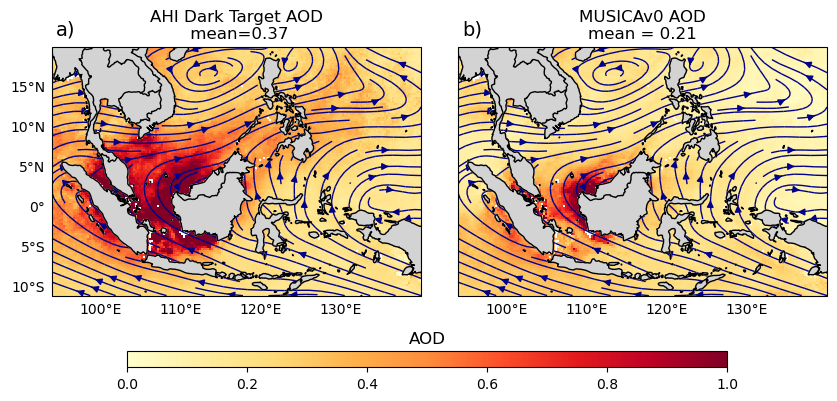

In [14]:
group_name = qa
longitude_min = 94
longitude_max = 140
latitude_min = -11  # Adjust as necessary
latitude_max = 20   # Adjust as necessary
##########################################
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size for better layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.1)  # Define 1 row, 2 columns

pla_proj = ccrs.PlateCarree()
ax1 = fig.add_subplot(gs[0], projection=pla_proj)
ax1.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

# Plot the mean_aod_ocean data
mean_aod_ocean.plot.pcolormesh(vmin=0, vmax=1, cmap='YlOrRd', ax=ax1, add_colorbar=False)
ds_wind_mean.plot.streamplot('lon','lat','U','V',color='darkblue',linewidth=1,density=1, ax=ax1, zorder=1)

land = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray')
ax1.add_feature(land)

ax1.coastlines(resolution='50m', color='black', linewidth=1)
ax1.add_feature(cf.BORDERS, linewidth=1, edgecolor='black',zorder=2)

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlines = False
gl.ylines = False
gl.right_labels = False 
gl.top_labels = False 

ahi_mean = mean_aod_ocean.where((mean_aod_ocean.latitude >= -11) & (mean_aod_ocean >=0)).mean().item()
plt.title(f'AHI Dark Target AOD\n mean={ahi_mean:.2f}')
ax1.text(94.5, 21.5, 'a)', fontsize=14, color='black',
        transform=ccrs.PlateCarree())
########################################################################
########################################################################
########################################################################
ax2 = fig.add_subplot(gs[1], projection=pla_proj)
ax2.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

ref = mean_aod_model_ocean.plot.pcolormesh(vmin=0,vmax=1,cmap='YlOrRd',ax=ax2, add_colorbar=False)
ds_wind_mean.plot.streamplot('lon','lat','U','V',color='darkblue',linewidth=1,density=1, ax=ax2, zorder=1)
ax2.add_feature(land)

ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2.add_feature(cf.BORDERS, linewidth=1, edgecolor='black',zorder=2)
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlines = False
gl.ylines = False
gl.right_labels = False 
gl.left_labels = False 
gl.top_labels = False 

musicav0_mean = mean_aod_model_ocean.where((mean_aod_model_ocean.lat >= -11) & (mean_aod_ocean >=0)).mean().item()
plt.title(f'MUSICAv0 AOD\nmean = {musicav0_mean:.2f}')
ax2.text(94.5, 21.5, 'b)', fontsize=14, color='black',
        transform=ccrs.PlateCarree())

# Create a common colorbar for both plots
cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.02])  # Adjust position as needed
plt.colorbar(ref, cax=cbar_ax, orientation='horizontal')
plt.title(f'AOD')
plt.savefig(f'img/Figure3_AMSPaper.png',dpi=300,bbox_inches='tight')

########################################################################
########################################################################
########################################################################

# 2D histogram

In [15]:
df_mean_aod_model = mean_aod_model.to_dataframe().reset_index().reset_index()
df_mean_aod_model

,index,lat,lon,AODVIS
0,0,-19.15160,93.940239,NaN
1,1,-19.15160,94.190407,NaN
2,2,-19.15160,94.440582,NaN
3,3,-19.15160,94.690758,NaN
4,4,-19.15160,94.940933,NaN
...,...,...,...,...
29383,29383,20.15299,139.221680,0.071059
29384,29384,20.15299,139.471863,0.068719
29385,29385,20.15299,139.722031,0.073471
29386,29386,20.15299,139.972198,0.070398


In [16]:
df_mean_aod = mean_aod.to_dataframe().reset_index().reset_index()
df_mean_aod['latitude']

0       -19.151599
1       -19.151599
2       -19.151599
3       -19.151599
4       -19.151599
           ...    
29383    20.152990
29384    20.152990
29385    20.152990
29386    20.152990
29387    20.152990
Name: latitude, Length: 29388, dtype: float64

In [17]:
merged_df = pd.merge(df_mean_aod, df_mean_aod_model, on=['index'], how='inner')
merged_df

,index,latitude,longitude,aod_Mean,lat,lon,AODVIS
0,0,-19.151599,93.940236,NaN,-19.15160,93.940239,NaN
1,1,-19.151599,94.190410,NaN,-19.15160,94.190407,NaN
2,2,-19.151599,94.440584,NaN,-19.15160,94.440582,NaN
3,3,-19.151599,94.690757,NaN,-19.15160,94.690758,NaN
4,4,-19.151599,94.940931,NaN,-19.15160,94.940933,NaN
...,...,...,...,...,...,...,...
29383,29383,20.152990,139.221682,0.133565,20.15299,139.221680,0.071059
29384,29384,20.152990,139.471855,0.138400,20.15299,139.471863,0.068719
29385,29385,20.152990,139.722029,0.140542,20.15299,139.722031,0.073471
29386,29386,20.152990,139.972203,0.157605,20.15299,139.972198,0.070398


In [18]:
merged_df_no_nan = merged_df[['index','AODVIS','aod_Mean']].dropna()
merged_df_no_nan

,index,AODVIS,aod_Mean
2604,2604,0.159143,0.150305
2605,2605,0.160644,0.145931
2606,2606,0.166447,0.156408
2607,2607,0.178924,0.135302
2608,2608,0.186346,0.145974
...,...,...,...
29383,29383,0.071059,0.133565
29384,29384,0.068719,0.138400
29385,29385,0.073471,0.140542
29386,29386,0.070398,0.157605


In [19]:
# Define bin edges
bins = np.arange(0, 2.2, 0.2)

# Bin the data and calculate the mean for each bin
merged_df_no_nan['aod_obs_bin'] = pd.cut(merged_df_no_nan['aod_Mean'], bins)
grouped_df = merged_df_no_nan.groupby('aod_obs_bin').mean()
grouped_df = grouped_df.reset_index()
grouped_df

,aod_obs_bin,index,AODVIS,aod_Mean
0,"(0.0, 0.2]",10387.089350,0.189647,0.170978
1,"(0.2, 0.4]",18309.972244,0.186184,0.279498
2,"(0.4, 0.6]",18144.656090,0.228599,0.478911
3,"(0.6, 0.8]",16526.659509,0.322292,0.698470
4,"(0.8, 1.0]",16149.480190,0.420323,0.886218
5,"(1.0, 1.2]",15141.602190,0.611437,1.083489
6,"(1.2, 1.4]",14623.338028,0.800580,1.296844
7,"(1.4, 1.6]",13981.647059,0.844381,1.487020
8,"(1.6, 1.8]",13655.604167,0.913236,1.708918
9,"(1.8, 2.0]",12691.800000,0.900340,1.894499


In [20]:
# Define bin edges
bins = np.arange(0, 2.2, 0.2)

# Bin the data and calculate the mean for each bin
grouped_df_std = merged_df_no_nan.groupby('aod_obs_bin').std()
grouped_df_std = grouped_df_std.reset_index()
grouped_df_std

,aod_obs_bin,index,AODVIS,aod_Mean
0,"(0.0, 0.2]",6554.389349,0.086515,0.021239
1,"(0.2, 0.4]",8020.447301,0.083918,0.055393
2,"(0.4, 0.6]",4970.452125,0.111400,0.054806
3,"(0.6, 0.8]",3562.347906,0.125668,0.057097
4,"(0.8, 1.0]",2982.326574,0.152530,0.058398
5,"(1.0, 1.2]",2241.800689,0.183710,0.057138
6,"(1.2, 1.4]",1764.938324,0.230551,0.057928
7,"(1.4, 1.6]",1899.255445,0.307886,0.053976
8,"(1.6, 1.8]",1922.302274,0.388013,0.055816
9,"(1.8, 2.0]",1725.708119,0.462734,0.060786


In [21]:
# Convert the bin labels to the bin centers for plotting
bin_centers = bins[:-1] + np.diff(bins) / 2
bin_centers


array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])

In [22]:
df_mean_aod_ocean = mean_aod_ocean.to_dataframe().reset_index().reset_index()
df_mean_aod_ocean

,index,latitude,longitude,aod_Mean
0,0,-19.151599,93.940236,NaN
1,1,-19.151599,94.190410,NaN
2,2,-19.151599,94.440584,NaN
3,3,-19.151599,94.690757,NaN
4,4,-19.151599,94.940931,NaN
...,...,...,...,...
29383,29383,20.152990,139.221682,0.133565
29384,29384,20.152990,139.471855,0.138400
29385,29385,20.152990,139.722029,0.140542
29386,29386,20.152990,139.972203,0.157605


In [23]:
df_mean_aod_model_ocean = mean_aod_model_ocean.to_dataframe().reset_index().reset_index()
df_mean_aod_model_ocean

,index,lat,lon,AODVIS
0,0,-19.15160,93.940239,NaN
1,1,-19.15160,94.190407,NaN
2,2,-19.15160,94.440582,NaN
3,3,-19.15160,94.690758,NaN
4,4,-19.15160,94.940933,NaN
...,...,...,...,...
29383,29383,20.15299,139.221680,0.071059
29384,29384,20.15299,139.471863,0.068719
29385,29385,20.15299,139.722031,0.073471
29386,29386,20.15299,139.972198,0.070398


In [24]:
# Merging DataFrames on latitude and longitude
merged_df_ocean = pd.merge(df_mean_aod_ocean, df_mean_aod_model_ocean, on=['index'], how='inner')
merged_df_ocean

,index,latitude,longitude,aod_Mean,lat,lon,AODVIS
0,0,-19.151599,93.940236,NaN,-19.15160,93.940239,NaN
1,1,-19.151599,94.190410,NaN,-19.15160,94.190407,NaN
2,2,-19.151599,94.440584,NaN,-19.15160,94.440582,NaN
3,3,-19.151599,94.690757,NaN,-19.15160,94.690758,NaN
4,4,-19.151599,94.940931,NaN,-19.15160,94.940933,NaN
...,...,...,...,...,...,...,...
29383,29383,20.152990,139.221682,0.133565,20.15299,139.221680,0.071059
29384,29384,20.152990,139.471855,0.138400,20.15299,139.471863,0.068719
29385,29385,20.152990,139.722029,0.140542,20.15299,139.722031,0.073471
29386,29386,20.152990,139.972203,0.157605,20.15299,139.972198,0.070398


In [25]:
merged_df_ocean_no_nan = merged_df_ocean[['index','AODVIS','aod_Mean']].dropna()
merged_df_ocean_no_nan


,index,AODVIS,aod_Mean
2604,2604,0.159143,0.150305
2605,2605,0.160644,0.145931
2606,2606,0.166447,0.156408
2607,2607,0.178924,0.135302
2608,2608,0.186346,0.145974
...,...,...,...
29383,29383,0.071059,0.133565
29384,29384,0.068719,0.138400
29385,29385,0.073471,0.140542
29386,29386,0.070398,0.157605


In [26]:
# Define bin edges
bins = np.arange(0, 2.2, 0.2)

# Bin the data and calculate the mean for each bin
merged_df_ocean_no_nan['aod_obs_bin'] = pd.cut(merged_df_ocean_no_nan['aod_Mean'], bins)
grouped_df_ocean = merged_df_ocean_no_nan.groupby('aod_obs_bin').mean()
grouped_df_ocean = grouped_df_ocean.reset_index()
grouped_df_ocean

,aod_obs_bin,index,AODVIS,aod_Mean
0,"(0.0, 0.2]",10387.089350,0.189647,0.170978
1,"(0.2, 0.4]",18309.972244,0.186184,0.279498
2,"(0.4, 0.6]",18144.656090,0.228599,0.478911
3,"(0.6, 0.8]",16526.659509,0.322292,0.698470
4,"(0.8, 1.0]",16149.480190,0.420323,0.886218
5,"(1.0, 1.2]",15141.602190,0.611437,1.083489
6,"(1.2, 1.4]",14623.338028,0.800580,1.296844
7,"(1.4, 1.6]",13981.647059,0.844381,1.487020
8,"(1.6, 1.8]",13655.604167,0.913236,1.708918
9,"(1.8, 2.0]",12691.800000,0.900340,1.894499


In [27]:
# Define bin edges
bins = np.arange(0, 2.2, 0.2)

# Bin the data and calculate the mean for each bin
grouped_df_ocean_std = merged_df_ocean_no_nan.groupby('aod_obs_bin').std()
grouped_df_ocean_std = grouped_df_ocean_std.reset_index()
grouped_df_ocean_std

,aod_obs_bin,index,AODVIS,aod_Mean
0,"(0.0, 0.2]",6554.389349,0.086515,0.021239
1,"(0.2, 0.4]",8020.447301,0.083918,0.055393
2,"(0.4, 0.6]",4970.452125,0.111400,0.054806
3,"(0.6, 0.8]",3562.347906,0.125668,0.057097
4,"(0.8, 1.0]",2982.326574,0.152530,0.058398
5,"(1.0, 1.2]",2241.800689,0.183710,0.057138
6,"(1.2, 1.4]",1764.938324,0.230551,0.057928
7,"(1.4, 1.6]",1899.255445,0.307886,0.053976
8,"(1.6, 1.8]",1922.302274,0.388013,0.055816
9,"(1.8, 2.0]",1725.708119,0.462734,0.060786


In [28]:
aerdt_land_mean = pd.read_csv('output/csv/aerdt_land_mean.csv')
aerdt_land_std = pd.read_csv('output/csv/aerdt_land_std.csv')
aerdt_land_mean

,Unnamed: 0,aod_obs_bin,index,AODVIS,aod_Mean
0,0,"(0.0, 0.2]",12586.268031,0.145320,0.149039
1,1,"(0.2, 0.4]",20733.132213,0.173093,0.290231
2,2,"(0.4, 0.6]",18967.967213,0.249032,0.490057
3,3,"(0.6, 0.8]",15326.221631,0.402409,0.688333
4,4,"(0.8, 1.0]",14626.707317,0.570183,0.889335
5,5,"(1.0, 1.2]",14447.820988,0.734185,1.087535
6,6,"(1.2, 1.4]",14267.454545,0.745329,1.278870
7,7,"(1.4, 1.6]",14394.833333,0.729259,1.476170
8,8,"(1.6, 1.8]",14769.000000,1.036453,1.667690
9,9,"(1.8, 2.0]",15312.500000,1.354690,1.899391


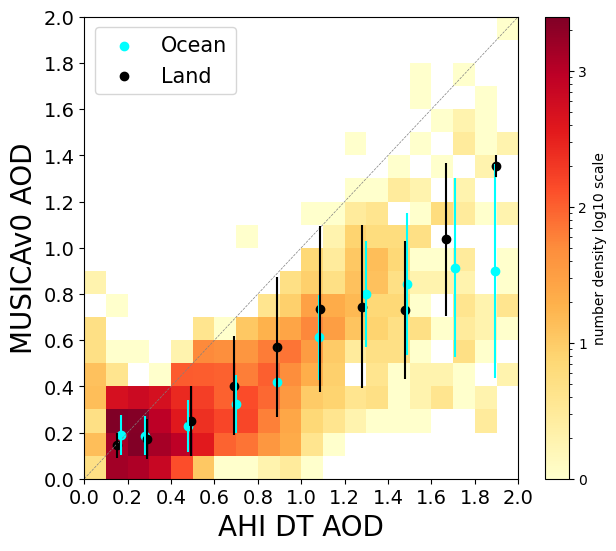

In [31]:
fig, ax1 = plt.subplots(figsize=(7, 6))

# Define bin edges
bins = np.arange(0, 2.1, 0.1)

#sns.kdeplot(x=merged_df['AODVIS'], y=merged_df['aod_Mean'], cmap="Blues", fill=True, thresh=0.05, bw_adjust=0.5)
#plt.hexbin(merged_df['AODVIS'], merged_df['aod_Mean'], gridsize=30, cmap='Blues', mincnt=1)
plt.hist2d(merged_df_no_nan['aod_Mean'], merged_df_no_nan['AODVIS'],  bins=[bins, bins], cmap='YlOrRd',norm=LogNorm())

cbar = plt.colorbar(label='number density log10 scale')
cbar.set_ticks([1, 10, 100, 1000])
cbar.set_ticklabels(['0', '1', '2', '3'])

ax1.plot([0, 3], [0, 3], color='gray', linestyle='--', linewidth=0.5)

ax1.scatter( grouped_df['aod_Mean'].values, grouped_df['AODVIS'].values,color='#00FFFF', label='Ocean')
ax1.scatter( aerdt_land_mean['aod_Mean'].values, aerdt_land_mean['AODVIS'].values,color='k', label='Land')
plt.legend(fontsize=15)
for i in range(len(grouped_df)):
    plt.vlines(x=grouped_df['aod_Mean'][i], ymin=grouped_df['AODVIS'][i] - grouped_df_std['AODVIS'][i], ymax=grouped_df['AODVIS'][i] + grouped_df_std['AODVIS'][i], color='#00FFFF')
for i in range(len(grouped_df)):
    plt.vlines(x=aerdt_land_mean['aod_Mean'][i], ymin=aerdt_land_mean['AODVIS'][i] - aerdt_land_std['AODVIS'][i], ymax=aerdt_land_mean['AODVIS'][i] + aerdt_land_std['AODVIS'][i], color='k')

ax1.set_xlabel('AHI DT AOD',fontsize=20)
ax1.set_ylabel('MUSICAv0 AOD',fontsize=20)
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
# Set ticks every 0.2
plt.xticks(np.arange(0, 2.1, 0.2),fontsize=14)
plt.yticks(np.arange(0, 2.1, 0.2),fontsize=14)

plt.savefig(f'img/Figure4_AMSPaper.png',dpi=300,bbox_inches='tight')
